# BNT

## Toy

In [1]:
import jax
import jax_cosmo as jc
import jax.numpy as jnp

print("JAX version:", jax.__version__)
print("jax-cosmo version:", jc.__version__)

JAX version: 0.5.0
jax-cosmo version: 0.1.0


In [2]:
# check if jax is using GPU
print("jax backend:", jax.lib.xla_bridge.get_backend().platform)

/tmp/ipykernel_3108351/2917079958.py:2: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print("jax backend:", jax.lib.xla_bridge.get_backend().platform)


jax backend: gpu


In [3]:
# That's our nz, from Nico
nz_unorm = lambda z : 1.8048 * ( z**0.4170 + z**(0.4170*4.8685) )/(z**4.8685 + 0.7841)

zmin = 0.001
zmax = 4.
nbins = 10 # Number of bins for photometric redshifts

In [4]:
# @title [Run me]

from scipy.integrate import simpson, quad
from scipy.optimize import brentq
from scipy.special import erf

zsamp = jnp.linspace(zmin, zmax,4096)
norm = simpson(nz_unorm(zsamp),zsamp)
nz = lambda z: nz_unorm(z)/norm

def subdivide( nbins, bintype='eq_dens'):
    """ Divide this redshift bins into sub-bins
        nbins : Number of bins to generate
        bintype : 'eq_dens' or 'eq_size'
    """
    # Compute the redshift boundaries for each bin generated
    zbounds = [zmin]
    bins = []
    n_per_bin = 1. / nbins
    for i in range(nbins-1):
        if bintype == 'eq_dens':
                zbound = brentq(lambda z: quad(nz,zmin,z)[0] - (i+1.0)*n_per_bin, zbounds[i], zmax)
        else:
            if bintype != 'eq_size':
                print ('WARNING : unknown binning scheme ' + bintype + '. Assuming equal size bins')
            zbound = (i+1.) * (zmax - zmin)/nbins

        zbounds.append(zbound)
    zbounds.append(zmax)
    return zbounds

photoz_bins = subdivide(10, bintype='eq_dens')

# Photoz distributions for first and last bins
def photz_unorm(z, zmin, zmax, zphot_sig=0.05):
    """ Computes the un-normalized n(z) """
    p = nz(z)

    # Apply photo-z errors
    x = 1.0/(jnp.sqrt(2.0)*zphot_sig*(1.0+z))
    res = 0.5* p *( erf((zmax - z )*x) - erf((zmin - z)*x))
    return res

# Building jax cosmo nz distributions
nzs_s = [jc.redshift.kde_nz(zsamp,
                            photz_unorm(zsamp, zmin=photoz_bins[i], zmax=photoz_bins[i+1]),
                            bw=(zmax - zmin)/4096,
                            gals_per_arcmin2=1./nbins)
           for i in range(0,nbins)]

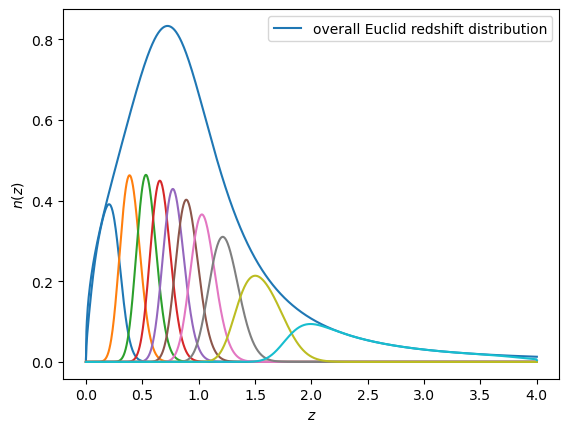

In [5]:
import matplotlib.pyplot as plt

# Plotting the distribution
z = jnp.linspace(0,4,1000);
plt.plot(z, nz(z), label='overall Euclid redshift distribution');

for i in range(nbins):
  plt.plot(z, nzs_s[i](z)*nzs_s[i].gals_per_arcmin2, color='C%d'%i)

plt.legend(loc='best');
plt.xlabel(r'$z$');
plt.ylabel(r'$n(z)$');

In [6]:
import jax_cosmo.background as bkgrd
from jax_cosmo.scipy.integrate import simps

# Build cosmology object
cosmo = jc.Planck15()

# Defining the function that computes the lensing efficiency kernel

In [7]:
from functools import partial

@jax.jit
@partial(jax.vmap, in_axes=(None, None, 0))
def lensing_efficiency(cosmo, dndz, z):
  chi = bkgrd.radial_comoving_distance(cosmo, jc.utils.z2a(z))

  def integrand(z_prime):
    chi_prime = bkgrd.radial_comoving_distance(cosmo, jc.utils.z2a(z_prime))
    return (dndz(z_prime) * jnp.clip(chi_prime - chi, 0) / jnp.clip(chi_prime, 1.0))

  return simps(integrand, z, zmax, 256) * (1.0 + z) * chi

/home/tersenov/anaconda3/envs/jax_new/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Text(0, 0.5, 'n(z) or lensing efficiency')

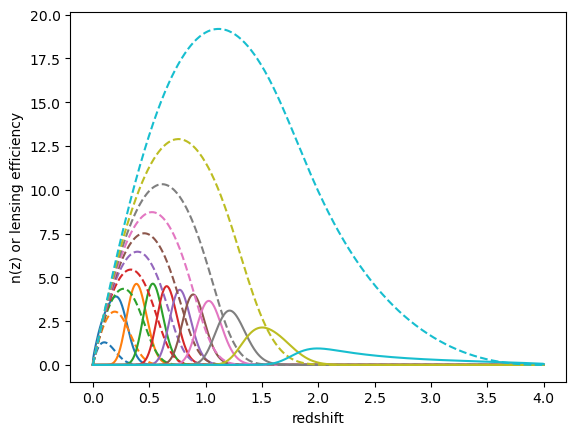

In [8]:
for i in range(nbins):
  plt.plot(z, nzs_s[i](z), color='C%d'%i)
  plt.plot(z, lensing_efficiency(cosmo, nzs_s[i], z)/100, color='C%d'%i, ls='--')

# xlim(0,1)
plt.xlabel('redshift')
plt.ylabel('n(z) or lensing efficiency')

In [9]:
# Computing the BNT transform as implemented here: https://github.com/pltaylor16/x-cut/blob/master/BNT.py
import numpy as np

class BNT():

    def __init__(self, z, chi, n_i_list):

        self.z = z
        self.chi = chi
        self.n_i_list = n_i_list
        self.nbins = len(n_i_list)


    def get_matrix(self):

        A_list = []
        B_list = []
        for i in range(self.nbins):
            nz = self.n_i_list[i]
            A_list += [np.trapz(nz, self.z)]
            B_list += [np.trapz(nz / self.chi, self.z)]

        BNT_matrix = np.eye(self.nbins)
        BNT_matrix[1,0] = -1.

        for i in range(2,self.nbins):
            mat = np.array([ [A_list[i-1], A_list[i-2]], [B_list[i-1], B_list[i-2]] ])
            A = -1. * np.array( [A_list[i], B_list[i]] )
            soln = np.dot(np.linalg.inv(mat), A)
            BNT_matrix[i,i-1] = soln[0]
            BNT_matrix[i,i-2] = soln[1]

        return BNT_matrix

In [10]:
z = np.linspace(0.001,4,1000)
bnt = BNT(z, bkgrd.radial_comoving_distance(cosmo, jc.utils.z2a(z)),
          [nzs_s[i](z) for i in range(nbins)])

M = bnt.get_matrix()

/tmp/ipykernel_3108351/1570149095.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  A_list += [np.trapz(nz, self.z)]
/tmp/ipykernel_3108351/1570149095.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  B_list += [np.trapz(nz / self.chi, self.z)]


In [11]:
M

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.1312819 , -1.13158983,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.47218334, -1.4721776 ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.63181666, -1.63181974,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.75129003, -1.75129493,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.85926102,
        -1.8592539 ,  1.        ,  0.        

In [12]:
# Looking at the resulting efficiency kernel after BNT transform
eff = np.zeros((10, len(z)))
for j in range(10):
  for i in range(nbins):
    eff[j] += M[j,i]*lensing_efficiency(cosmo, nzs_s[i], z).squeeze()

Text(0.5, 0, 'Redshift')

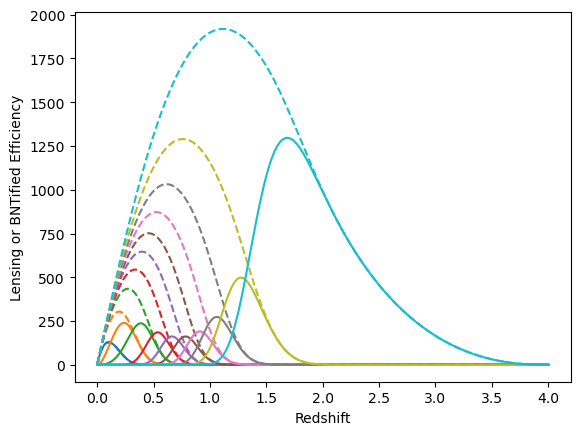

In [13]:
for i in range(nbins):
  plt.plot(z, lensing_efficiency(cosmo, nzs_s[i], z),'--',color='C%d'%i)
  plt.plot(z, eff[i,:],  color='C%d'%i,)

plt.ylabel('Lensing or BNTified Efficiency')
plt.xlabel('Redshift')
# xlim(0,2)

## cosmoGRID

In [14]:
import numpy as np

# Load data from a txt file into a NumPy array
nz1 = np.loadtxt('/home/tersenov/CosmoGridV1/stage3_forecast/nz/nz_stage3_1.txt')
nz2 = np.loadtxt('/home/tersenov/CosmoGridV1/stage3_forecast/nz/nz_stage3_2.txt')
nz3 = np.loadtxt('/home/tersenov/CosmoGridV1/stage3_forecast/nz/nz_stage3_3.txt')
nz4 = np.loadtxt('/home/tersenov/CosmoGridV1/stage3_forecast/nz/nz_stage3_4.txt')

In [15]:
nz_unorm = np.zeros((1000, 2)) 
nz_unorm[:,0] = nz1[:,0]
nz_unorm[:,1] = nz1[:,1] + nz2[:,1] + nz3[:,1] + nz4[:,1]

(0.0, 2.0)

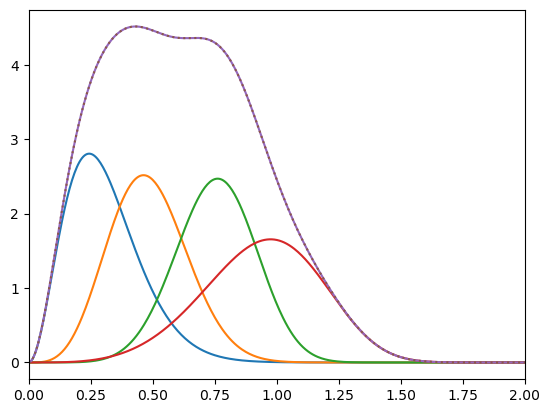

In [16]:
# plot n(z)
plt.plot(nz1[:,0], nz1[:,1])
plt.plot(nz2[:,0], nz2[:,1])
plt.plot(nz3[:,0], nz3[:,1])
plt.plot(nz4[:,0], nz4[:,1])
plt.plot(nz1[:,0], nz1[:,1]+nz2[:,1]+nz3[:,1]+nz4[:,1])
plt.plot(nz_unorm[:,0], nz_unorm[:,1], linestyle=':')
plt.xlim(0,2)

In [32]:
import jax
import jax_cosmo as jc
import jax.numpy as jnp

print("JAX version:", jax.__version__)
print("jax-cosmo version:", jc.__version__)

JAX version: 0.5.0
jax-cosmo version: 0.1.0


In [33]:
nz1_kde = jc.redshift.kde_nz(nz1[:,0], nz1[:,1], bw=0.005)
nz2_kde = jc.redshift.kde_nz(nz2[:,0], nz2[:,1], bw=0.005)
nz3_kde = jc.redshift.kde_nz(nz3[:,0], nz3[:,1], bw=0.005)
nz4_kde = jc.redshift.kde_nz(nz4[:,0], nz4[:,1], bw=0.005)
nz_unorm_kde = jc.redshift.kde_nz(nz_unorm[:,0], nz_unorm[:,1], bw=0.005)

(0.0, 2.0)

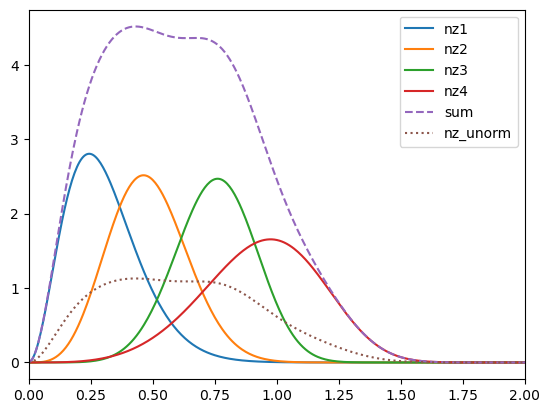

In [34]:
z = jnp.array(np.linspace(0,5,1000))
plt.plot(z, nz1_kde(z), label='nz1')
plt.plot(z, nz2_kde(z), label='nz2')
plt.plot(z, nz3_kde(z), label='nz3')
plt.plot(z, nz4_kde(z), label='nz4')
plt.plot(z, nz1_kde(z)+nz2_kde(z)+nz3_kde(z)+nz4_kde(z), linestyle='--', label='sum')
plt.plot(z, nz_unorm_kde(z), linestyle=':', label='nz_unorm')
plt.legend()
plt.xlim(0,2)

In [20]:
zmin = 0
zmax = 5.

In [21]:
import jax_cosmo.background as bkgrd
from jax_cosmo.scipy.integrate import simps

# Build cosmology object
cosmo = jc.Planck15()

# Defining the function that computes the lensing efficiency kernel

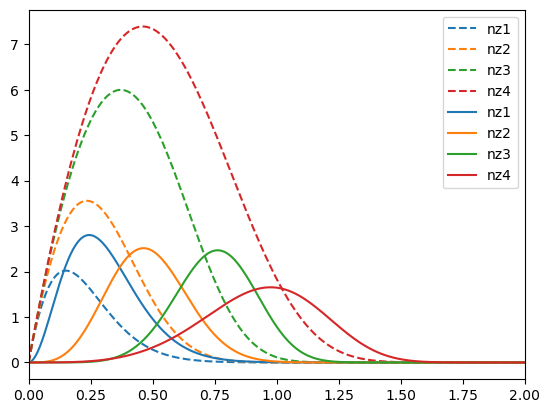

In [22]:
plt.plot(z, lensing_efficiency(cosmo, nz1_kde, z)/100, color='C0', label='nz1', linestyle='--')
plt.plot(z, lensing_efficiency(cosmo, nz2_kde, z)/100, color='C1', label='nz2', linestyle='--')
plt.plot(z, lensing_efficiency(cosmo, nz3_kde, z)/100, color='C2', label='nz3', linestyle='--')
plt.plot(z, lensing_efficiency(cosmo, nz4_kde, z)/100, color='C3', label='nz4', linestyle='--')

plt.plot(z, nz1_kde(z), color='C0', label='nz1')
plt.plot(z, nz2_kde(z), color='C1', label='nz2')
plt.plot(z, nz3_kde(z), color='C2', label='nz3')
plt.plot(z, nz4_kde(z), color='C3', label='nz4')

plt.xlim(0,2)
plt.legend()

In [23]:
# Computing the BNT transform as implemented here: https://github.com/pltaylor16/x-cut/blob/master/BNT.py
import numpy as np

class BNT():

    def __init__(self, z, chi, n_i_list):

        self.z = z
        self.chi = chi
        self.n_i_list = n_i_list
        self.nbins = len(n_i_list)


    def get_matrix(self):

        A_list = []
        B_list = []
        for i in range(self.nbins):
            nz = self.n_i_list[i]
            A_list += [np.trapz(nz, self.z)]
            B_list += [np.trapz(nz / self.chi, self.z)]

        BNT_matrix = np.eye(self.nbins)
        BNT_matrix[1,0] = -1.

        for i in range(2,self.nbins):
            mat = np.array([ [A_list[i-1], A_list[i-2]], [B_list[i-1], B_list[i-2]] ])
            A = -1. * np.array( [A_list[i], B_list[i]] )
            soln = np.dot(np.linalg.inv(mat), A)
            BNT_matrix[i,i-1] = soln[0]
            BNT_matrix[i,i-2] = soln[1]

        return BNT_matrix

In [24]:
nbins = 4
nzs_s = [nz1_kde, nz2_kde, nz3_kde, nz4_kde]

In [25]:
bnt = BNT(z, bkgrd.radial_comoving_distance(cosmo, jc.utils.z2a(z)),
            [nzs_s[i](z) for i in range(nbins)])
M = bnt.get_matrix()

/tmp/ipykernel_3108351/1570149095.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  A_list += [np.trapz(nz, self.z)]
/tmp/ipykernel_3108351/1570149095.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  B_list += [np.trapz(nz / self.chi, self.z)]


In [26]:
eff = np.zeros((4, len(z)))
for j in range(4):
  for i in range(nbins):
    eff[j] += M[j,i]*lensing_efficiency(cosmo, nzs_s[i], z).squeeze()

In [27]:
M

array([[ 1.,  0.,  0.,  0.],
       [-1.,  1.,  0.,  0.],
       [nan, nan,  1.,  0.],
       [ 0., nan, nan,  1.]])

(0.0, 2.0)

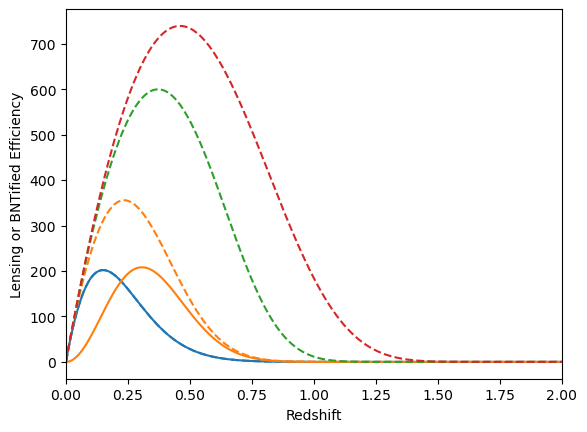

In [28]:
for i in range(nbins):
  plt.plot(z, lensing_efficiency(cosmo, nzs_s[i], z),'--',color='C%d'%i)
  plt.plot(z, eff[i,:],  color='C%d'%i,)
plt.ylabel('Lensing or BNTified Efficiency')
plt.xlabel('Redshift')
plt.xlim(0,2)